# Convolutional Variational Autoencoder

# Import libraries

In [1]:
import os
from glob import glob
from utils.custom_utils import RetrieveData, show_images
import random as rd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Download data

In [2]:
DataURL='https://tinyurl.com/mr2yc5nx'

RetrieveData(DataURL)

## Dataloader and data check

In [3]:
image_path='./data/images_gz2/images'

In [4]:
class GalaxyZoo2(Dataset):
    def __init__(self, img_dir, transform=None, train=None, dataset_size=None):
        self.transform = transform
        self.img_dir = img_dir
        
        images = glob(os.path.join(img_dir,'*.jpg'))
        rd.shuffle(images)
        images=images[:dataset_size]
        
        cut = int(0.6*len(images))
        if train==True:
            self.images = images[:cut]
        elif train==False:
            self.images = images[cut:]
        else:
            self.images = images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = self.images[index]
        with Image.open(img_path) as im:
            if self.transform:
                im = self.transform(im)
            return im/255

In [5]:
trainset=GalaxyZoo2(image_path, transform=transforms.PILToTensor(), dataset_size=1000)

In [6]:
trainloader=DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)

torch.Size([10, 3, 424, 424])


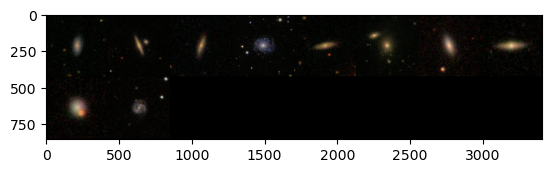

In [7]:
images=next(iter(trainloader))
print(images.shape)
show_images(utils.make_grid(images))

## VAE

In [8]:
class Conv_VAE(nn.Module):
    def __init__(self,channels=3, featureDim=64*412*412,latent_dim=2):
        super().__init__()
        
        self.encoder = nn.Sequential(nn.Conv2d(channels, 16, 5),
                                     nn.ReLU(),
                                     nn.Conv2d(16, 32, 5),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, 5),
                                     nn.ReLU(),
                                     nn.Flatten(),
                                    )
        
        self.mu = nn.Linear(featureDim, latent_dim)
        self.logvar = nn.Linear(featureDim, latent_dim)
        
        self.latent_mapping = nn.Linear(latent_dim, featureDim)
        
        self.decoder = nn.Sequential(nn.Unflatten(-1,(64,412,412)),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(64, 32, 5),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 16, 5),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(16, channels, 5),
                                    )
    
    def encode(self, x):
        encoder = self.encoder(x)
        mu, logvar = self.mu(encoder), self.logvar(encoder)
        return mu, logvar
    
    def sample_z(self, mu, logvar):
        eps = torch.rand_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        latent_z = self.latent_mapping(z)
        out = self.decoder(latent_z)
        return torch.sigmoid(out)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample_z(mu, logvar)
        output = self.decode(z)
        return output, mu, logvar

In [9]:
def ElboLoss(x, x_reconstructed, mu, sigma, alpha=1):
    criterion = F.binary_cross_entropy(x_reconstructed, x)
    KL_div = -0.5*torch.sum(1+sigma-mu**2-torch.exp(sigma))
    elbo = torch.mean(criterion + alpha * KL_div)
    return elbo

## Training

In [14]:
def train_Conv(num_epochs, alpha=1):
    """
    Train the model (VAE) onto the data in the trainloader
    """
    train_avg_loss = []
    
    
    for i in range(num_epochs):
        train_losses = []
        loop = tqdm(enumerate(trainloader))
        
        for i,x in loop:
            x = x.to(device)
            x_reconstructed, mu, logvar = model(x)
        
            loss = ElboLoss(x, x_reconstructed, mu, logvar, alpha=alpha)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())
            train_losses.append(loss.detach())
                    
        train_avg_loss.append(torch.mean(torch.FloatTensor(train_losses)))

    return train_avg_loss #we could also return the reconstruction loss and the regularization loss individually, but in the end it is the ELBO loss that is important

## Model 1

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'this instance use {device}')

torch.manual_seed(100)


image_size = 424
channels = 3
batch_size = 32

learning_rate = 3e-4 # arbitrary
num_epochs = 10 # arbitrary

model_name='Conv_VAE_1'

this instance use cuda


In [16]:
trainset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor(),]), train=True, dataset_size=1000)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [17]:
model = Conv_VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_avg_loss = train_Conv(10,alpha=1e-6)

0it [00:00, ?it/s]

In [ ]:
torch.save(model, os.path.join('models',model_name+'.pt'))

In [ ]:
plt.plot(train_avg_loss)
plt.title('loss')
plt.show()

In [ ]:
model=model.to('cpu')

In [ ]:
testset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor()]), train=False, dataset_size=1000)
testloader = DataLoader(testset,batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
mus=[]
sigmas=[]
for testimages in iter(testloader):

    testmu,testsigma=model.encode(testimages.view(testimages.shape[0],-1))
    mus.append(testmu.detach().numpy())
    sigmas.append(testsigma.detach().numpy())
mus=np.concatenate(mus)
sigmas=np.concatenate(sigmas)
plt.plot(mus[:,0],mus[:,1],'+')
plt.show()